# Differentiating RTD

# Auxilary part (import common dependencies)

In [1]:
## 
## This code uses modification of Giotto-PH (with properly enabled usage for r-cross-barcodes and
##                                           with output of simplex pairs)
##
## For any usage of code from this notebook this package MUST be installed

!pip install git+https://github.com/ArGintum/giotto-ph-ench.git@rtd-version 

  Cloning https://github.com/ArGintum/giotto-ph-ench.git (to revision rtd-version) to /tmp/pip-req-build-vvxr2e4v
  Running command git clone -q https://github.com/ArGintum/giotto-ph-ench.git /tmp/pip-req-build-vvxr2e4v
  Running command git checkout -b rtd-version --track origin/rtd-version
  Switched to a new branch 'rtd-version'
  Branch 'rtd-version' set up to track remote branch 'rtd-version' from 'origin'.
  Running command git submodule update --init --recursive -q
  Created wheel for giotto-ph: filename=giotto_ph-0.1.0-cp37-cp37m-linux_x86_64.whl size=373616 sha256=767811f76008df3b383bed5ef2fb908c70fc13f8a8387f3566f0c2ea09b6a7d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-2af5poxf/wheels/88/3a/fe/b5692461f703b29e478c387da99a47ae4d5296477f8c13bb01
Successfully built giotto-ph


In [2]:
%matplotlib inline

import itertools
import numpy as np
import matplotlib.pyplot as plt

from gph.python import ripser_parallel

## PyTorch implementation

In [3]:
import torch
import torch.nn as nn

#### For usage in any app copy this cell 'As is'
def Rips(DX, dim, card):
    # GUDHI version
    # Parameters: DX (distance matrix), 
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)
    if dim < 1:
        dim = 1
    rc = ripser_parallel(DX, maxdim=dim, metric="precomputed", collapse_edges=False)

    dgm = rc['dgms'][dim]
    pairs = rc['pairs'][dim]

    # Retrieve vertices v_a and v_b by picking the ones achieving the maximal
    # distance among all pairwise distances between the simplex vertices
    indices, pers = [], []
    for i in range(len(pairs)):
        s1, s2 = pairs[i]
        if len(s1) == dim+1 and len(s2) > 0:
            l1, l2 = np.array(s1), np.array(s2)
            i1 = [s1[v] for v in np.unravel_index(np.argmax(DX[l1,:][:,l1]),[len(s1), len(s1)])]
            i2 = [s2[v] for v in np.unravel_index(np.argmax(DX[l2,:][:,l2]),[len(s2), len(s2)])]
            indices += i1
            indices += i2
            pers.append(dgm[i][1] - dgm[i][0])
    
    # Sort points with distance-to-diagonal
    perm = np.argsort(pers)
    indices = list(np.reshape(indices, [-1,4])[perm][::-1,:].flatten())
    
    # Output indices
    indices = indices[:4*card] + [0 for _ in range(0,max(0,4*card-len(indices)))]
    return list(np.array(indices, dtype=np.int32))

class RTD_differentiable(nn.Module):
    def __init__(self, r1, r2, dim=1, card=50, mode='quantile'):
        super(RTD_differentiable, self).__init__()

        if r1.shape[0] != r2.shape[0]:
            raise ValueError('Point clouds must have same size')

        if mode != 'quantile' and mode != 'median':
            raise ValueError('Only "quantile" or "median" modes are supported')

        self.r1 = r1
        self.r2 = r2
        self.dim = dim
        self.card = card
        self.mode = mode
        
    def call(self):
        d, c = self.dim, self.card
        
        # Compute distance matrices
        Dr1 = torch.cdist(self.r1, self.r1)
        Dr2 = torch.cdist(self.r2, self.r2)

        Dr12 = torch.minimum(Dr1, Dr2)
        Dzz = torch.zeros((len(self.r1), len(self.r1)))

        DX = torch.cat((torch.cat((Dzz, Dr1), 1), torch.cat((Dr1, Dr12), 1)), 0)
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        ids = np.array(Rips(DX.detach(), self.dim, self.card), dtype=np.long)
        
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        if d > 0:
            tmp_idx = np.reshape(ids, [2*c,2])
            dgm = torch.reshape(DX[tmp_idx[:, 0], tmp_idx[:, 1]], [c,2])
        else:
            tmp_idx = np.reshape(ids, [2*c,2])[1::2,:]
            dgm = torch.cat([torch.zeros([c,1]), torch.reshape(DX[tmp_idx[:,0], tmp_idx[:,1]], [c,1])], 1)
        return dgm

### How to use this (example)

In [4]:
np.random.seed(1)
seed_11 = np.random.normal(loc=0.0, scale=0.0, size=(10, 2))
seed_12 = np.random.normal(loc=0.0, scale=0.0, size=(0, 2))
seed_12[:, 0] += 1.0
#cloud_1 = seed_11
cloud_1 = np.vstack([seed_11, seed_12])

seed_21 = np.random.normal(loc=0.0, scale=0.0, size=(9, 2))
seed_22 = np.random.normal(loc=0.0, scale=0.0, size=(1, 2))
seed_22[:, 0] += 1.0
cloud_2 = np.vstack([seed_21, seed_22])

Text(0.5, 1.0, 'Cloud prior to transformation')

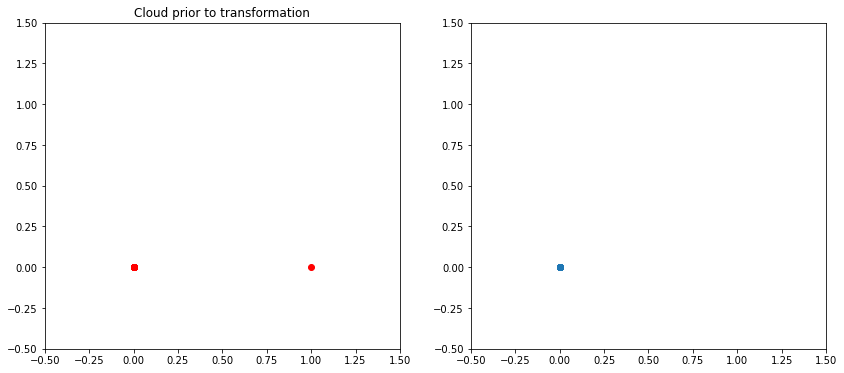

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.set_xlim(-0.5, 1.5)
ax1.set_ylim(-0.5, 1.5)
ax2.set_xlim(-0.5, 1.5)
ax2.set_ylim(-0.5, 1.5)

ax2.scatter(cloud_1[:,0], cloud_1[:,1])
ax1.scatter(cloud_2[:,0], cloud_2[:,1], c='r')
ax1.set_title('Cloud prior to transformation')

In [16]:
### Increasing total length of H1 intervals

X1 = torch.tensor(cloud_2, requires_grad=True) # R1. If R1 is unmovable, change to <requires_grad=False>
X2 = torch.tensor(cloud_1, requires_grad=True) # R2. If R2 is unmovable, change to <requires_grad=False>

parameters = [X1, X2] # If R1 is unmovable, change to < [X2] >, if R2 is unmovable, change to < [X1] >.

model = RTD_differentiable(r1=X1, r2=X2, dim=1, card=400) # Parameters of RipsModel():
                                                             # dim            - only persistence pairs of this dimension (one number) will be considered
                                                             # card
model2 = RTD_differentiable(r1=X2, r2=X1, dim=1, card=400)

lr_init = 1e-0        # ! IMPORTANT: learning rate requires cloud-specific adjustment 

optimizer = torch.optim.SGD(parameters, lr = lr_init, momentum=0.)

lambda_1 = lambda epoch: 0.95 ** (epoch // 1)  # Learning rate decay shedule requires cloud-specific adjustment 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda_1])

losses, dgms = [], []

EPOCHS = 1001    # Number of steps
for epoch in range(EPOCHS):
    dgm = model.call()
    dgm = dgm[dgm[:, 1] > 0]

    dgm2 = model2.call()
    dgm2 = dgm2[dgm2[:, 1] > 0]
    loss = torch.sum(dgm[:, 1] - dgm[:,0]) + torch.sum(dgm2[:, 1] - dgm2[:, 0]) # Increasing total length of H1 intervals

    np.random.seed(epoch)

    loss.backward()
    optimizer.step()
    scheduler.step()

    losses.append((torch.sum(dgm[:,1]-dgm[:,0]) + torch.sum(dgm2[:, 1] - dgm2[:, 0]) ).detach().numpy())
    dgms.append(dgm)
    X1.grad.zero_()       # ! IMPORTANT: COMMENT OUT this line if R1 is unmobale
    X2.grad.zero_()       # ! IMPORTANT: COMMENT OUT this line if R2 is unmobale

#### Some examples


Red - r2, Blue - r1. Moving only r1. lr_init =  1.0


Text(0.5, 1.0, 'Cloud after 1001 iterations (unequal scaling)')

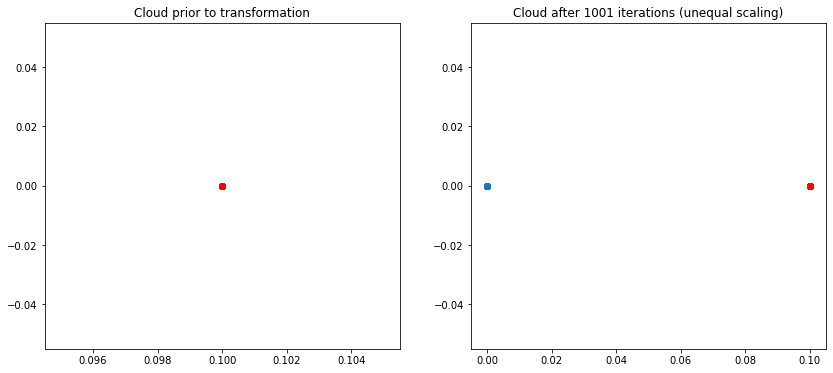

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
print('Red - r2, Blue - r1. Moving only r1. lr_init = ', lr_init)

#ax1.set_xlim(-0.5, 1.5)
#ax1.set_ylim(-0.5, 1.5)

#ax2.set_xlim(-0.5, 1.5)
#ax2.set_ylim(-0.5, 1.5)

#ax1.scatter(cloud_1[:,0], cloud_1[:,1])
#ax1.scatter(cloud_2[:,0], cloud_2[:,1], c='r')
ax1.scatter(model.r1.detach().numpy()[:,0], model.r1.detach().numpy()[:,1], c='r')
ax1.set_title('Cloud prior to transformation')

ax2.scatter(model.r1.detach().numpy()[:,0], model.r1.detach().numpy()[:,1], c='r')
ax2.scatter(model.r2.detach().numpy()[:,0], model.r2.detach().numpy()[:,1])
ax2.set_title('Cloud after ' + str(epoch + 1) + ' iterations (unequal scaling)')

Red - r2, Blue - r1. Moving only r1. lr_init =  1.0
1.3877787807814457e-17


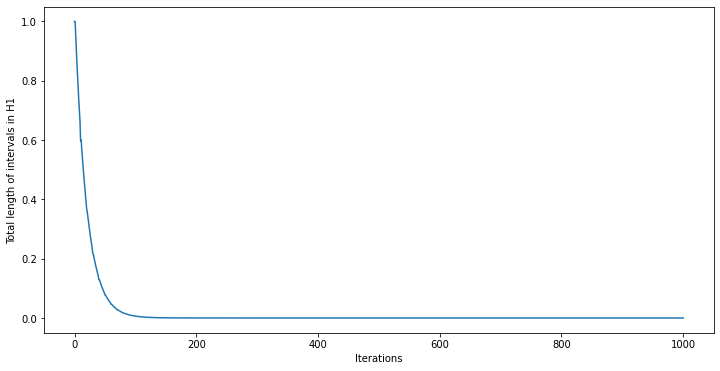

In [11]:
plt.figure(figsize=(12,6))
print('Red - r2, Blue - r1. Moving only r1. lr_init = ', lr_init)
plt.plot(np.array(losses))
plt.xlabel('Iterations')
plt.ylabel('Total length of intervals in H1')
print(losses[-1])

In [14]:
np.random.seed(1)
seed_11 = np.random.normal(loc=0.0, scale=0.1, size=(50, 2))
seed_12 = np.random.normal(loc=0.0, scale=0.1, size=(50, 2))
seed_12[:, 0] += 1.0
#cloud_1 = seed_11
cloud_1 = np.vstack([seed_11, seed_12])

seed_21 = np.random.normal(loc=0.0, scale=0.1, size=(90, 2))
seed_22 = np.random.normal(loc=0.0, scale=0.1, size=(10, 2))
seed_22[:, 0] += 1.0
cloud_2 = np.vstack([seed_21, seed_22])

Text(0.5, 1.0, 'Cloud prior to transformation')

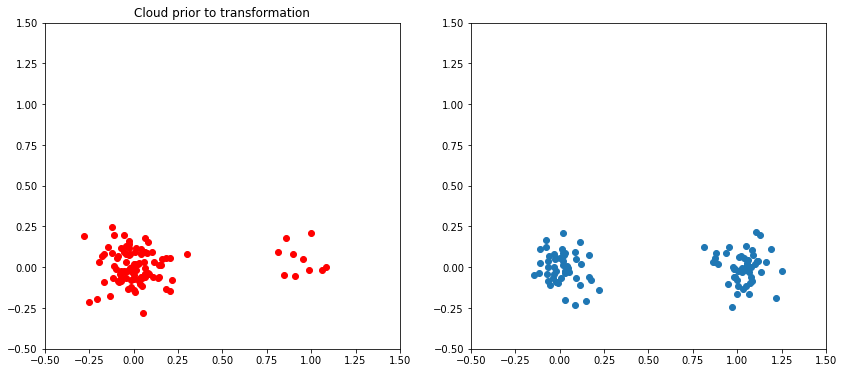

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.set_xlim(-0.5, 1.5)
ax1.set_ylim(-0.5, 1.5)
ax2.set_xlim(-0.5, 1.5)
ax2.set_ylim(-0.5, 1.5)

ax2.scatter(cloud_1[:,0], cloud_1[:,1])
ax1.scatter(cloud_2[:,0], cloud_2[:,1], c='r')
ax1.set_title('Cloud prior to transformation')

In [30]:
### Increasing total length of H1 intervals

X1 = torch.tensor(cloud_2, requires_grad=True) # R1. If R1 is unmovable, change to <requires_grad=False>
X2 = torch.tensor(cloud_1, requires_grad=False) # R2. If R2 is unmovable, change to <requires_grad=False>

parameters = [X1] # If R1 is unmovable, change to < [X2] >, if R2 is unmovable, change to < [X1] >.

model = RTD_differentiable(r1=X1, r2=X2, dim=1, card=400) # Parameters of RipsModel():
                                                             # dim            - only persistence pairs of this dimension (one number) will be considered
                                                             # card
model2 = RTD_differentiable(r1=X2, r2=X1, dim=1, card=400)

lr_init = 1e-1        # ! IMPORTANT: learning rate requires cloud-specific adjustment 

optimizer = torch.optim.SGD(parameters, lr = lr_init, momentum=0.)

lambda_1 = lambda epoch: 0.95 ** (epoch // 10)  # Learning rate decay shedule requires cloud-specific adjustment 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda_1])

losses, dgms = [], []

EPOCHS = 1001    # Number of steps
for epoch in range(EPOCHS):
    dgm = model.call()
    dgm = dgm[dgm[:, 1] > 0]

    dgm2 = model2.call()
    dgm2 = dgm2[dgm2[:, 1] > 0]
    loss = torch.sum(dgm[:, 1] - dgm[:,0]) + torch.sum(dgm2[:, 1] - dgm2[:, 0]) # Increasing total length of H1 intervals

    np.random.seed(epoch)

    loss.backward()
    optimizer.step()
    scheduler.step()

    losses.append((torch.sum(dgm[:,1]-dgm[:,0]) + torch.sum(dgm2[:, 1] - dgm2[:, 0]) ).detach().numpy())
    dgms.append(dgm)
    X1.grad.zero_()       # ! IMPORTANT: COMMENT OUT this line if R1 is unmobale
    #X2.grad.zero_()       # ! IMPORTANT: COMMENT OUT this line if R2 is unmobale

Red - r2, Blue - r1. Moving only r1. lr_init =  0.1


Text(0.5, 1.0, 'r2 after 1001 iterations (unequal scaling)')

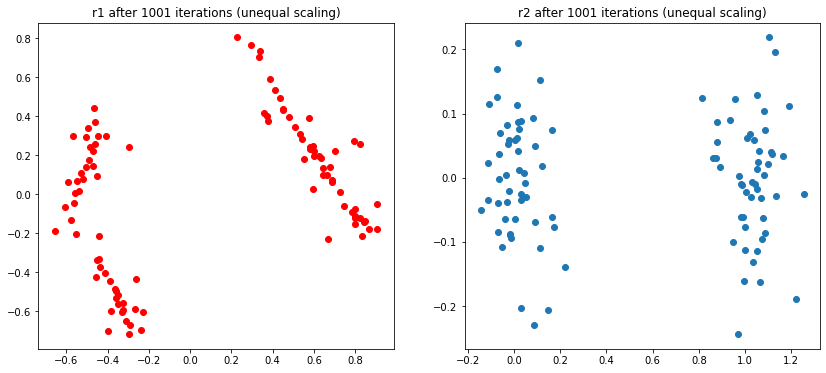

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
print('Red - r2, Blue - r1. Moving only r1. lr_init = ', lr_init)

#ax1.set_xlim(-0.95, 1.5)
#ax1.set_ylim(-0.95, 1.5)
#ax2.set_xlim(-0.95, 1.5)
#ax2.set_ylim(-0.95, 1.5)

ax1.scatter(model.r1.detach().numpy()[:,0], model.r1.detach().numpy()[:,1], c='r')
ax1.set_title('r1 after ' + str(epoch + 1) + ' iterations (unequal scaling)')

ax2.scatter(model.r2.detach().numpy()[:,0], model.r2.detach().numpy()[:,1])
ax2.set_title('r2 after ' + str(epoch + 1) + ' iterations (unequal scaling)')

Red - r2, Blue - r1. Moving only r1. lr_init =  0.1
1.343318054680639


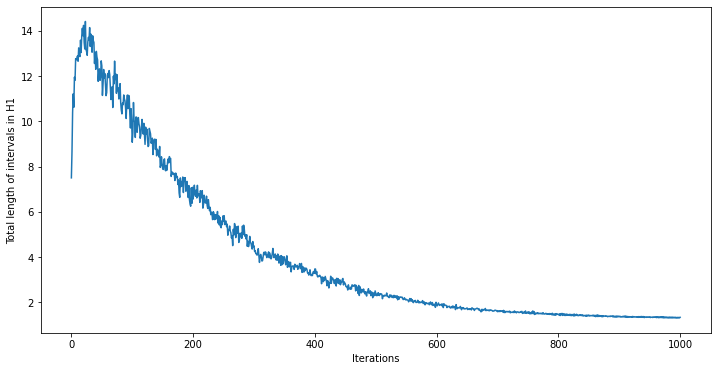

In [32]:
plt.figure(figsize=(12,6))
print('Red - r2, Blue - r1. Moving only r1. lr_init = ', lr_init)
plt.plot(np.array(losses))
plt.xlabel('Iterations')
plt.ylabel('Total length of intervals in H1')
print(losses[-1])

**NOTES:**

 - ```model.call()``` return persistence pairs as array of shape ```card```$ \times 2$. Elements of each pair represent birth/death moments derived from points positions in Tensorflow compputational graph for autogradient.

- Transformed clouds (result) can be found at ```model.r1.detach().numpy()``` and ```model.r2.detach().numpy()```


 - Known issues:
   1. Do NOT use ```dgm[i,0]``` when working with $H_0$ (birth moments of 0-dimensional persistence pairs are always zero anyways) - it will ruin everything. Birth moments in this case are fictional and don't depend on points positions, thus autogradient may fail. So, for decreasing total length of $H_0$ persistence intervals may be used (for example):
      
      ```
      loss = torch.sum(dgm[:,1])
      ```
  2. If there are less persistence pairs than ```card``` parameter states, last lines of ```model.call()``` output (as it is always contains ```card``` pairs) will be filled with ```(0, 0)```. Thats why line ```dgm = dgm[dgm[:, 1] > 0]``` is needed - it cuts that tail away.
  
- Some examples of loss functions:
  - For decreasing total length of $H_1$ intervals may be used 
    
    ``` loss = torch.sum(dgm[:,1]-dgm[:,0])```
  - For increasing birth moments of $H_1$ intervals may be used

    ```loss = -torch.sum(dgm[:,0])```
  - For increasing death moments of $H_1$ intervals may be used

    ```loss = torch.sum(dgm[:,1])```
